# Fake news detection with traditional approach

This notebook presents ML models for predicting if a news text is fake or not using traditional ML techniques such as clustering, ensamble methods or bayes.

## Load data

In [1]:
!pip install jupyterlab
!pip install notebook
!pip install pandas
!pip install ydata-profiling
!pip install ipywidgets
!pip install transformers==4.17
!pip install torch
!pip install scikit-learn
!pip install tensorflow==2.15.1
!pip install keras==2.15.0
!pip install tf-keras
!pip install tensorflow_hub
!pip install mlxtend

In [140]:
import pandas as pd
from transformers import AutoModel, BertTokenizerFast, TFBertModel, AutoTokenizer, BertTokenizer
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,Input,Concatenate
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import re
from sklearn.cluster import KMeans
import joblib

%matplotlib inline

In [3]:
has_gpu = False if len(tf.config.list_physical_devices('GPU')) == 0 else True

In [4]:
url='https://drive.google.com/file/d/1cT8q8-rU-5T7TEKAB5oGkIAhS6dOD3O9/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]

data = pd.read_csv(url, delimiter=';')
data.head()

,site,retweetCount,quoteCount,likeCount,replyCount,rawContent,retweetedTweet,quotedTweet,real
0,eltiempo,13,0,23,1,☀️¡Buenos días! Amanecemos con las noticias má...,False,False,1
1,eltiempo,0,0,1,0,#Deportes | Dayro Moreno: el insólito regalo q...,False,False,1
2,eltiempo,0,0,5,2,"Néstor Lorenzo, el técnico de la Selección, ah...",False,False,1
3,eltiempo,2,0,4,1,"🔴#EnVivo | Diego Torres, representante de los ...",False,False,1
4,eltiempo,1,0,0,0,🔴 Bienvenido a #CityNoticiasMD. Conéctese para...,False,False,1


## Data analysis

### Dictionary

Dataset contains the following fields

- site: Twitter account that tweeted the news, we divided this in two categories, official and recognized new sites (e.g. @eltiempo, @noticiascaracol) and twitter accounts that are recognized for publishing fake news as a satire (e.g. @actualidadpanam, @ChiguireBipolar)
- retweetCount: How many retweets does the tweet have.
- quoteCount: How many quotes does the tweet have.
- likeCount: How many likes does the tweet have.
- replyCount: How many replies does the tweet have.
- rawContent: The raw text of the tweet.
- retweetedTweet: True if the tweet is a retweet, this means that the user did not publish the news but instead retweet it from another site. False if is not a retweet tweet.
- quotedTweet: True if the tweet is a quote, this means that the user did not publish the news but instead quoted it from another site. False if is not a quote from another tweet.
- real: Label that means if the news is fake or not. True if is a real news, False if considered fake.


### Profiling

We start profiling our data in order to analyze their structure.

In [5]:
ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

From the profiling we found the following insights:

- There are 0.7% duplicate rows which means the dataset contains repeated tweets, we should eliminate this data.
- There is no missing data.
- Site is highly correlated with the label (real), this is expected since all official news sites tweets were considered as real and satire site news were all considered as fake. This is only a informatory field and we should remove it.
- retweetCount, quoteCount, likeCount, replyCount has multiple zeroes and are highly skewed since some accounts may be more famous than others and also some tweets may have been more popular than others. We should not consider this fields considering also that they have high correlation between them.
- retweetedCount and quotedTweed are highly imbalanced this means that the majority of tweets were fully written by the author, we should remove the retweeted and quoted ones cause we do not have information if the account that did the original tweet is realiable or not in order to consider the tweet as fake or real.
- real is balanced so we have almost the same amount for fake and real tweets which is ideal.

## Data transformations

We are going to apply required transformations in order for the algorithms to interpret the text and also we want to remove fields and data entries that were found as not necessary after executing the profiling.

In [6]:
data = data[data['retweetedTweet'] != True]
data = data[data['quotedTweet'] != True]

In [7]:
bins = [0, 100, 5000, float('inf')]
labels = [0, 1, 2]

data['tweetPopularity'] = pd.cut(data['likeCount'], bins=bins, labels=labels, right=False)

In [8]:
data = data.drop(columns=[
  'retweetCount', 'quoteCount', 'likeCount', 'replyCount', 'site', 'retweetedTweet', 'quotedTweet'
])
data = data.drop_duplicates()

In [9]:
def preprocess_text(text):
    # Transform URLs
    text = re.sub(r'http\S+', '<URL>', text)

    # Transform other user mentions
    text = re.sub(r'@\w+', '<USUARIO>', text)

    # Delete emojis
    text = re.sub(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U000024C2-\U0001F251]+', '', text)
    text = re.sub(r':\)|;\)|:-\)|:-\(|:-\(|:-\*|:-\)|:P|:D|:<|:-P', '<EMOJI>', text)


    # Transform hashtags
    text = re.sub(r'#\w+', '<HASH_TAG>', text)

    return text

In [10]:
data['preprocessedContent'] = data['rawContent'].apply(preprocess_text)

In [11]:
data.head()

,rawContent,real,tweetPopularity,preprocessedContent
0,☀️¡Buenos días! Amanecemos con las noticias má...,1,0,¡Buenos días! Amanecemos con las noticias más ...
1,#Deportes | Dayro Moreno: el insólito regalo q...,1,0,<HASH_TAG> | Dayro Moreno: el insólito regalo ...
2,"Néstor Lorenzo, el técnico de la Selección, ah...",1,0,"Néstor Lorenzo, el técnico de la Selección, ah..."
3,"🔴#EnVivo | Diego Torres, representante de los ...",1,0,"<HASH_TAG> | Diego Torres, representante de lo..."
4,🔴 Bienvenido a #CityNoticiasMD. Conéctese para...,1,0,Bienvenido a <HASH_TAG>. Conéctese para conoc...


In [12]:
ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Split data

In [13]:
df_X = data
df_y = data['real']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, random_state=2024, test_size=0.2)

## Tokenize data

In [15]:
tokenizer = AutoTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')

special_tokens_dict = {'additional_special_tokens': ['<HASH_TAG>', '<USUARIO>', '<URL>', '<EMOJI>']}
tokenizer.add_special_tokens(special_tokens_dict)

4

In [16]:
example_text = [data.iloc[0]['preprocessedContent']]
tokenizer.batch_encode_plus(example_text, padding=True, return_token_type_ids=False)

{'input_ids': [[4, 1120, 2931, 2041, 1109, 4742, 12557, 1048, 1085, 4306, 1186, 3521, 1040, 17732, 30958, 1081, 1707, 1008, 9799, 9024, 10553, 1297, 1008, 31004, 31004, 5]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

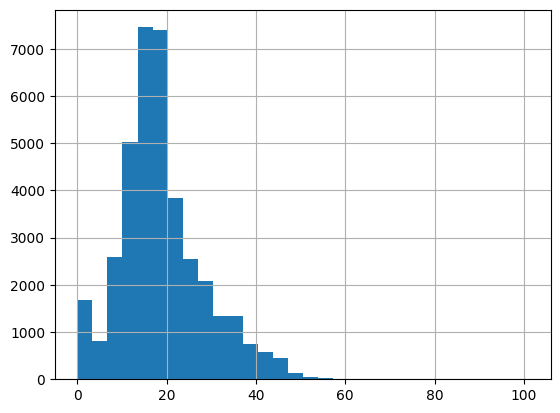

In [17]:
seq_len = [len(i.split()) for i in data['preprocessedContent']]
pd.Series(seq_len).hist(bins=30)
plt.show()

In [18]:
max_seq_len = 30

In [49]:
def tokenize(text_data):
    return tokenizer(
        text = list(text_data),
        add_special_tokens = True,
        max_length = max_seq_len,
        truncation = True,
        padding = 'max_length',
        return_tensors = 'tf',
        return_token_type_ids = False,
        return_attention_mask = True,
        verbose = True
    )


In [20]:
X_train_tokenize = tokenize(X_train['preprocessedContent'])
X_test_tokenize = tokenize(X_test['preprocessedContent'])

2024-05-17 02:35:06.128804: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-05-17 02:35:06.129052: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38554 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0


In [21]:
X_train_popularity = tf.convert_to_tensor(X_train['tweetPopularity'], dtype=tf.float32)
X_test_popularity = tf.convert_to_tensor(X_test['tweetPopularity'], dtype=tf.float32)

## Build model

In [22]:
bert_model = TFBertModel.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')

Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
def create_model():
    dropout_rate = 0.2
    input_ids = Input(shape=(max_seq_len,), dtype=tf.int32)
    input_mask = Input(shape=(max_seq_len,), dtype=tf.int32)
    popularity_input = Input(shape=(1,), dtype=tf.float32)

    bert_layer=bert_model([input_ids,input_mask])[1]
    concatenated_features = Concatenate()([bert_layer, popularity_input])

    x = Dropout(0.2)(concatenated_features)
    x = Dense(32, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=[input_ids, input_mask, popularity_input], outputs=x)
    return model

In [24]:
model=create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1098508   ['input_1[0][0]',             
 )                           ngAndCrossAttentions(last_   80         'input_2[0][0]']             
                             hidden_state=(None, 30, 76                                           
                             8),                                                              

In [25]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-05, epsilon=1e-08, clipnorm=1.0)

In [26]:
callback = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, min_delta=0.0001, restore_best_weights=True)

In [27]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'], run_eagerly=True)

## Train model

In [28]:
first_input_key =  model.layers[0].name
second_input_key = model.layers[1].name
third_input_key = model.layers[3].name

In [29]:
history = model.fit(
    x={
      f'{first_input_key}': X_train_tokenize['input_ids'],
      f'{second_input_key}': X_train_tokenize['attention_mask'],
      f'{third_input_key}': X_train_popularity
    },
    y=y_train,
    epochs=3,
    validation_split=0.2,
    batch_size=128,
    callbacks=[callback]
)

Epoch 1/3


2024-05-17 02:35:19.314841: I external/local_xla/xla/service/service.cc:168] XLA service 0x56464c576ee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-17 02:35:19.314882: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2024-05-17 02:35:19.321232: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-17 02:35:19.339462: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1715913319.483073   86999 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


191/191 [==============================] - 180s 826ms/step - loss: 0.7421 - accuracy: 0.5058 - val_loss: 0.6921 - val_accuracy: 0.4860
Epoch 2/3
191/191 [==============================] - 146s 762ms/step - loss: 0.6929 - accuracy: 0.5079 - val_loss: 0.6928 - val_accuracy: 0.5140
Epoch 3/3
191/191 [==============================] - 144s 755ms/step - loss: 0.6931 - accuracy: 0.5065 - val_loss: 0.6929 - val_accuracy: 0.5140


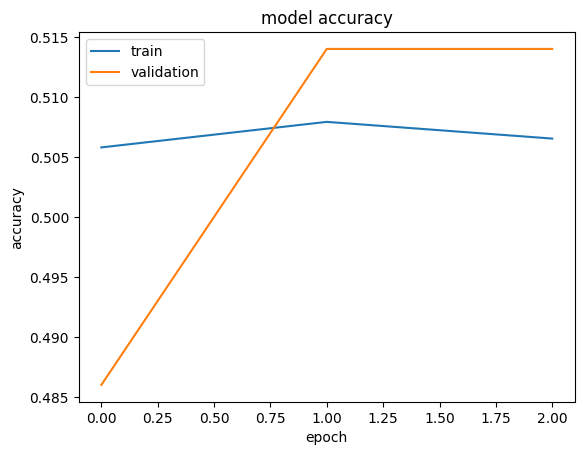

In [81]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

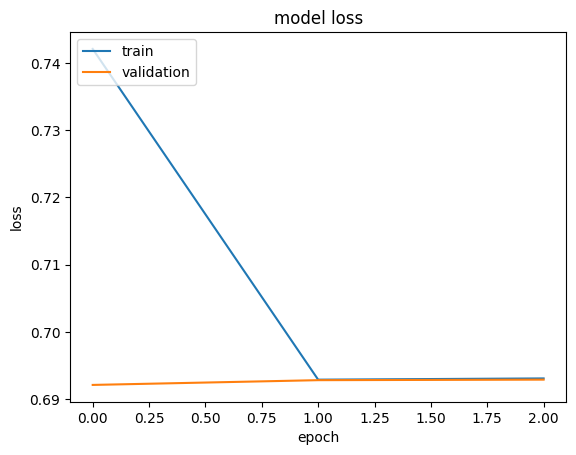

In [82]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Validate test

In [83]:
y_pred = np.where(
    model.predict({
        f'{first_input_key}' : X_test_tokenize['input_ids'] ,
        f'{second_input_key}' : X_test_tokenize['attention_mask'],
        f'{third_input_key}': X_test_popularity
    }) >=0.5,1,0
)

239/239 [==============================] - 45s 190ms/step


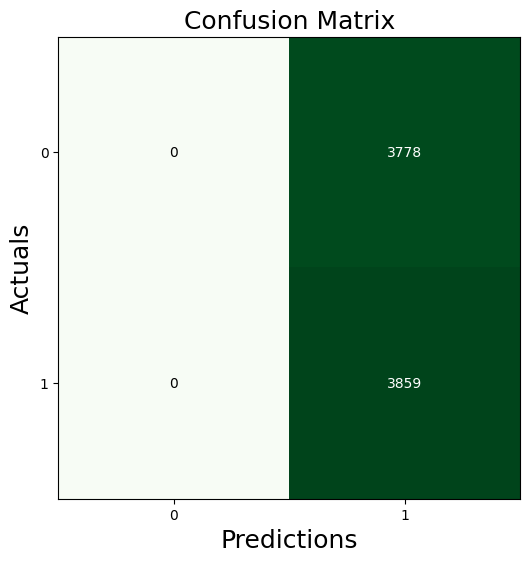

In [84]:
conf_matrix = confusion_matrix(y_test,y_pred)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

## Predict new data

In [130]:
new_test_text = pd.Series(["Barcelona gana la champions league 2024 y contrata a Zidane como entrenador principal luego de que Laporta tocara la guitarra."])
new_test_popularity = pd.Series([1])

In [131]:
new_test_text_tokenize = tokenize(new_test_text)
new_test_popularity_tensor = tf.convert_to_tensor(new_test_popularity, dtype=tf.float32)

In [132]:
test_text_pred = model.predict({
        f'{first_input_key}' : new_test_text_tokenize['input_ids'] ,
        f'{second_input_key}' : new_test_text_tokenize['attention_mask'],
        f'{third_input_key}': new_test_popularity_tensor
})

1/1 [==============================] - 0s 227ms/step


In [139]:
if(test_text_pred[0][0]>=0.85):
    print("News is Fake")
else:
    print("News is Real")

News is Real


## Save model

In [141]:
joblib.dump(model, 'twitter_model.pkl')

['twitter_model.pkl']